### Build and train a Recurrent Neural Network (RNN) of the type LSTM 
to predict $X(k)$ and $Y(k)$  as respectively  $\tilde{X(k)}$ an  $\tilde{Y(k)}$ based on inputs

Predictions on testing set are done in [RNN_Sim_StLaurentDeJourdes](RNN_Sim_StLaurentDeJourdes.ipynb)

---

In [1]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf
import joblib

In [2]:
# import pakages forML
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# import psutil
function_folder = '../Modules/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

from oriVariables import (network_folder)

#### Import data Cleaned file for training the RNN

In [9]:
df_data = joblib.load(network_folder+'simulationResults/cleanedData.pkl')

# Extract only a part of data to be used as 
df_data = df_data[df_data.index<='2021 12 31']

#### Feature engineering

In [32]:
# Add categorical data
df_data['Month'] = df_data.index.month
df_data['hour'] = df_data.index.hour

# # Separate training and validation set 
df_train = df_data[df_data.index<'2021 06 01']
df_val = df_data[df_data.index>='2021 06 01']


# Extract only dayligth period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. 
# Each day total period is therefore given by 10*6
h_start_end = ('07:00','18:50')
per_index = df_data.index

per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])

#### Plot data

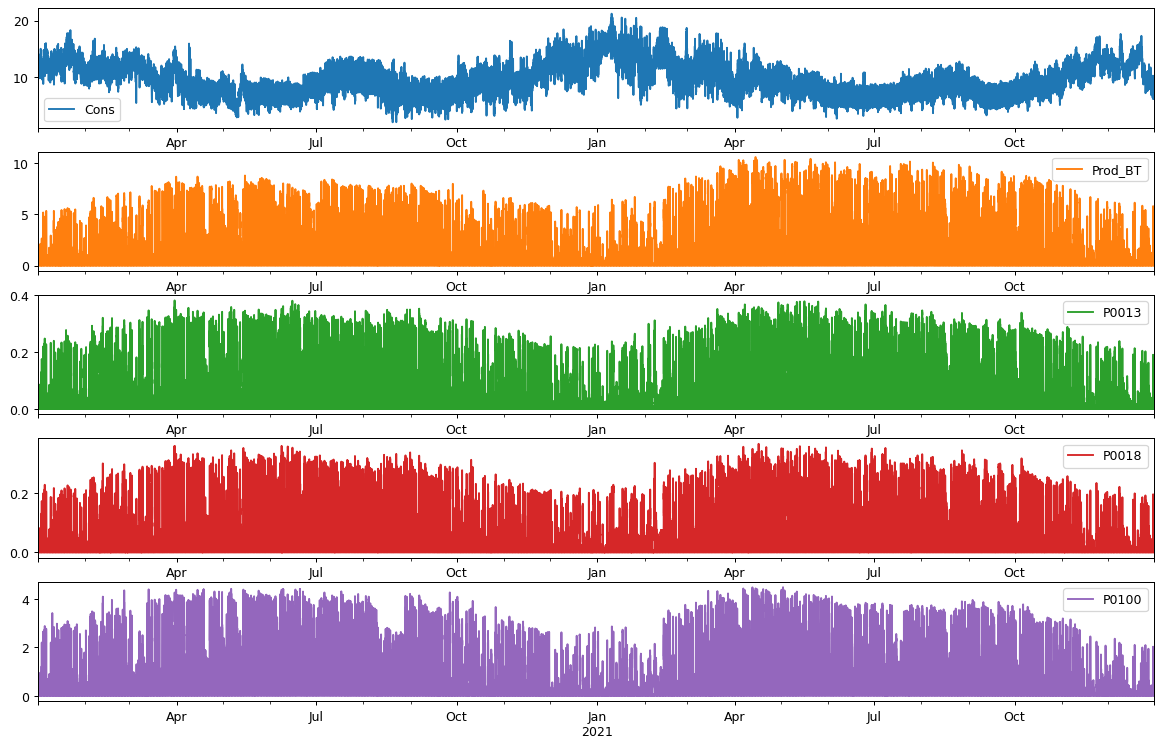

In [33]:
fig, axx = plt.subplots(5,figsize=(16,10),dpi=90)
df_data.iloc[:,:-2].plot(subplots=True,ax=axx);

#### Train RNN

In [34]:
from sklearn.compose import ColumnTransformer

In [35]:
# Define Scalers
numerical_scaler = MinMaxScaler()    

n_features = 5   
n_catVars = 2    # Total numbers of categorical variables 

# Define types columns  
cat_cols = df_train.columns[-n_catVars:]  # Categorical Column i.e ['Month', Hour]
num_cols = df_train.columns[:-n_catVars]  # Numerical Columns  i.e all others

# Define a prepreocessor
preprocessor = ColumnTransformer([('MinMaxScaler',  numerical_scaler, num_cols)
                                 ])

numerical_scaler.fit(df_train.iloc[:,:-n_catVars])# Fit trainig set to preprocessor 

# Transform training and testing set following the fitting previously donne
train_scaled, test_scaled = map(numerical_scaler.transform,[df_train.iloc[:,:-n_catVars], 
                                                            df_val.iloc[:,:-n_catVars] ] 
                               )

##### Define Timeseries  generators


In [36]:
batchSize = 60;
train_generator = TimeseriesGenerator(train_scaled, train_scaled, 
                                      length = day_tot_per, 
                                      batch_size= batchSize)

test_genarator = TimeseriesGenerator(test_scaled, test_scaled, 
                                     length = day_tot_per, 
                                     batch_size= batchSize)


##### Defnine the RNN

In [37]:
from tensorflow.keras.optimizers import SGD

In [38]:
rnn_model = Sequential() # Call sequential RNN

# Add RNN layers
rnn_model.add(LSTM(256, activation='relu', input_shape=(day_tot_per, n_features), return_sequences=True))
rnn_model.add(LSTM(256, activation='relu'))

# Add last Dense layer
rnn_model.add(Dense(n_features, activation='relu'))

# Compile RNN
rnn_model.compile(optimizer='adam', loss='mse',metrics=['accuracy'] )

##### Define early stoping mecanism to stop training when overfitting start occuring


In [39]:
# Define early stoping mecanism to stop training when overfitting start occuring
early_stop = EarlyStopping(monitor= 'val_loss',patience=30, mode='min')

##### Train Model

In [ ]:
rnn_model.fit(train_generator, 
          epochs=100, 
          callbacks=[early_stop],
          validation_data=test_genarator,)

##### Plot learnnig curves

<AxesSubplot:>

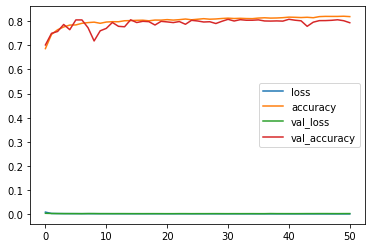

In [20]:
pd.DataFrame(rnn_model.history.history).plot()

In [ ]:
# Save Trained model 
rnn_model.save(f'{network_folder}RNN/StLaurent_Final')

In [ ]:
joblib.dump(numerical_scaler, f'{network_folder}RNN/StLaurent_Final_Scaler.pkl')